# Part 1 - Data collection

## Initial setup

In [15]:
# Import required libraries

import praw                       # To crawl Reddit and collect data
import pandas as pd               # To work with csv files
import matplotlib.pyplot as plt   # To plot graphs
import requests                   # To send POST requests
import time                       # To track time stamp of submissions
import pickle                     # To save and load the data we collect

In [2]:
# Initialise a Reddit object using Praw. You're going to need to create an OAuth client to reproduce the results.
# To create a client: https://www.reddit.com/prefs/apps

# Enter your credentials here before proceeding
client_id = ###
client_secret = ###
user_agent = ###
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

## Initial crawl
To get an idea of the kind of data we're working with.

In [3]:
# To store all the posts we're going to crawl
posts = []

# Create an object of the subreddit of interest, i.e. r/india
all_posts = reddit.subreddit('india').top(limit = None)

# Iterate over all the posts and add them to list
for post in all_posts:
    flair = post.link_flair_text
    if flair==None or flair.isascii()==False:
        continue
    posts.append([post.title, post.url, flair.strip().lower()])
    
# Store the result in a Pandas DataFrame
df = pd.DataFrame(posts, columns = ['title', 'url', 'flair'])

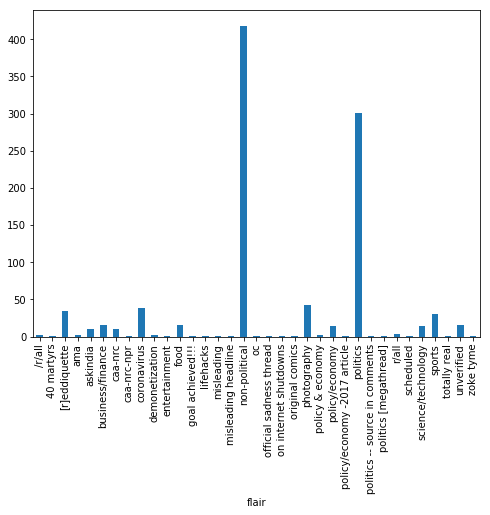

In [4]:
# Plot a bar graph of the different flairs present

fig = plt.figure(figsize=(8,6))
df.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

Note that flairs such as 'goal achieved!!!' and 'on internet shutdowns' appear to be very infrequent and not follow any standard flair category listed on the subreddit's rule page. So we'll only work with the major flairs present.

## Crawling the appropriate data
One of the problems with the Praw API is that it only lets you access 1000 posts per request. To overcome this limitation, after every 1000 posts that we collect, we'll note the time stamp of the last post collected, and then collect the 1000 posts preceding that time, and so on.

In [5]:
# To fetch the next batch of posts from the subreddit

def crawl_page(subreddit, prev_crawl):
    
    # The parameters for the POST request
    params = {"subreddit": subreddit, "size": 500, "sort": "desc", "sort_type": "created_utc"}
    
    # If this is not the first crawl, then add the last time stamp to the dictionary of parameters, 
    if prev_crawl!=None:
        params["before"] = prev_crawl[-1]["created_utc"]
        
    # Return the results of the POST request
    return (requests.get(url, params)).json()["data"]

In [6]:
posts = []                                                  # To store the posts that we crawl
prev_crawl = None                                           # Results of the previous crawl
limit = 300000                                              # Number of submissions to collect
url = "https://api.pushshift.io/reddit/search/submission"   # URL for the POST request


In [7]:
# Keep collecting data until we reach the desired limig

while len(posts)<limit:
    
    # Get the new batch of posts
    prev_crawl = crawl_page('india', prev_crawl)
    
    # Add this batch to our results
    posts += prev_crawl
    
    # Wait before making the next request
    time.sleep(3)
    
posts = posts[:limit]

## Filtering the data

It takes several minutes to run the previous block. I ran it once and saved the result in a Pickle file. We'll load that and proceed.

In [16]:
with open('all_data', 'rb') as fp:
    posts = pickle.load(fp)

In [17]:
# As mentioned above, we'll only consider the major flairs, namely 15 of them
flairs = ["Sports", "Politics", "AskIndia", "Business/Finance", "Food", "Science/Technology", "Non-Political", "Photography", "Policy/Economy", "Scheduled", "[R]eddiquette", "Food", "Coronavirus", "Demonetization", "CAA-NRC"]

filtered_data = []
for post in posts:
    
    # Discard the post if it has no flair or if the available flair is not relevant
    if 'link_flair_text' not in post.keys():
        continue
    if post['link_flair_text'] not in flairs:
        continue
    filtered_data.append([post['id'], post['title'], post['score'], post['link_flair_text']])

filtered_data = pd.DataFrame(filtered_data, columns = ['id', 'title', 'score', 'flair'])

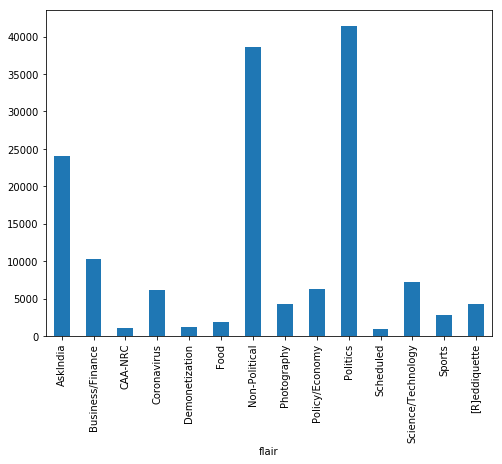

In [10]:
# Visualise the data

fig = plt.figure(figsize=(8,6))
filtered_data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

The data seems to be very unbalanced. We have two options: <br>
<ol>
    <li>Balance the data.</li>
    <li> Let our classifier be biased towards flairs like Politics given that we know that the discussion about politics won't chamge much on the subreddit. </li>
</ol>
I chose to go with the first one because the first one is insensitive to trends like the growing discussion about topics like Coronavirus.    

In [18]:
freq = {}                      # Frequency dictionary
threshold = 2500               # Maximum number of data points for each flair
count = 0                      # Number of categories that have hit the threshold
for flair in flairs:
    freq[flair] = 0

In [19]:
balanced_data = []
filtered_data = filtered_data.sort_values(['score'], ascending=False)
for _, post in filtered_data.iterrows():
    
    # Ignore this post if its flair has hit the threshold
    if freq[post['flair']]==threshold:
        continue
        
    balanced_data.append([post['id'], post['title'], post['flair'], post['score']])
    freq[post['flair']] += 1;
    
    # If the newly added flair has hit its threshold, increase count
    if freq[post['flair']]==threshold:
        count += 1
        
    # If all the flairs have hit their threshold, break the loop
    if count==len(flairs):
        break

balanced_data = pd.DataFrame(balanced_data, columns = ['id', 'title', 'flair', 'score'])

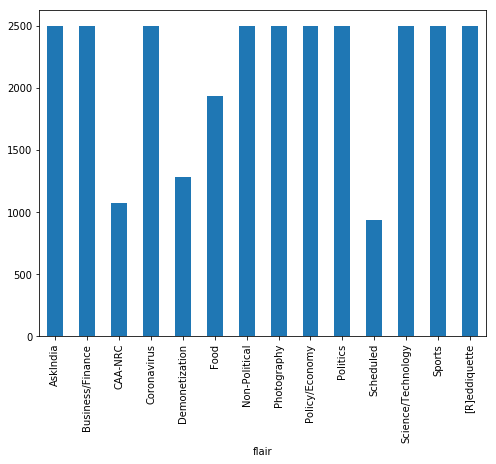

In [13]:
# Visualise the balanced data

fig = plt.figure(figsize=(8,6))
balanced_data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [14]:
# Save all the data we've collected

filtered_data.to_csv('filtered_data.csv', index=False)
balanced_data.to_csv('balanced_data.csv', index=False)
with open('all_data', 'wb') as fp:
    pickle.dump(posts, fp)